In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
from matplotlib import cm
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
from scipy.interpolate import RectBivariateSpline
from scipy.stats import kurtosis, skew
import scipy.optimize as optimize
from iminuit import Minuit

from ipywidgets import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import sncosmo
from sncosmo.salt2utils import BicubicInterpolator

from astropy.table import Table

%matplotlib inline

# Read the data

In [2]:
# file data paths
data_path = ".//SN_surfaces//"
file_names = glob.glob(data_path+"*.dat")
# rewrite the names
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][15:]
print("Total files in path: ", len(file_names))

Total files in path:  160


# To split the test and train dataset

In [3]:
# split our data in training and test dataset with ration 70 - 30 %
np.random.seed(42)
sn_train, sn_test = train_test_split(file_names, test_size=0.3)
print(len(sn_train), len(sn_test))

112 48


In [4]:
#Create a log file with training and testing dataset names
f = open(".//log//train_names.txt", 'w')
for i in range(0, len(sn_train)):
    f.write(str(sn_train[i][:-4])+"\n")
f.close()

f = open(".//log//test_names.txt", 'w')
for i in range(0, len(sn_test)):
    f.write(str(sn_test[i][:-4])+"\n")
f.close()

# Training the model

## Principal Component Analysis

In [5]:
TRAIN_DATASET=[]

# read the training dataset
for i in range(0, len(sn_train)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_train[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TRAIN_DATASET.append(np.array(SN["flux"]))

In [6]:
TRAIN_DATASET

[array([0.0084208 , 0.0109204 , 0.0139021 , ..., 0.001092  , 0.00105594,
        0.00100701]),
 array([ 0.188935  ,  0.229551  ,  0.269172  , ..., -0.00721102,
        -0.00847923, -0.00947001]),
 array([ 0.171012  ,  0.209274  ,  0.245043  , ..., -0.00503667,
        -0.00493225, -0.00471572]),
 array([2.46391e-01, 2.94884e-01, 3.43337e-01, ..., 1.67086e-03,
        9.43364e-04, 3.19163e-04]),
 array([0.232784  , 0.266146  , 0.297218  , ..., 0.0030573 , 0.00291071,
        0.00274195]),
 array([0.634037  , 0.632445  , 0.627347  , ..., 0.00127001, 0.00113795,
        0.00102184]),
 array([0.0555463 , 0.0830339 , 0.108819  , ..., 0.00185001, 0.00173738,
        0.00164899]),
 array([0.420281  , 0.475729  , 0.523938  , ..., 0.00754533, 0.00729468,
        0.00705347]),
 array([0.227961  , 0.278174  , 0.323892  , ..., 0.00413326, 0.00390446,
        0.00364665]),
 array([0.337683  , 0.350249  , 0.359859  , ..., 0.00163477, 0.00117764,
        0.00072277]),
 array([ 0.372752  ,  0.362447  

In [7]:
# Number of components 
N=10

In [8]:
np.random.random(42)
# apply pca with N components
pca = PCA(N)
pca.fit(TRAIN_DATASET);

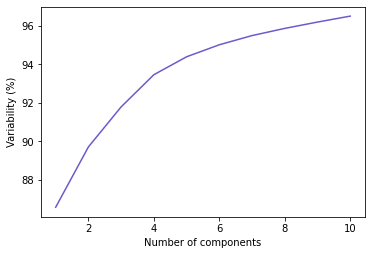

In [9]:
plt.plot(np.linspace(1, 10, 10, dtype=int), np.cumsum(pca.explained_variance_ratio_)*100, color="slateblue")
plt.xlabel('Number of components')
plt.ylabel('Variability (%)')
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

#plt.savefig("/home/joao/Desktop/variabilidade_acumulada.png", dpi = 200)   # save the figure to file

In [10]:
print("Explained variance in 3 components: ", pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2])

Explained variance in 3 components:  0.9177836873127625


In [11]:
# grid plot
x_grid = np.linspace(-10,50,61)
y_grid = np.linspace(3500,8000, 451)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

### Mean surface

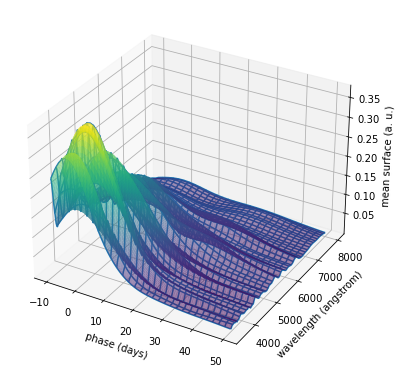

In [12]:
#matplotlib notebook

Z = interp.griddata((SN["phase"],SN["wave"]),pca.mean_,(B1,B2),method='cubic')
#Z = splinemean(B1, B2)
fig = plt.figure(figsize=(7, 5))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
ax.set_xlabel("phase (days)")
ax.set_ylabel("wavelength (angstrom)")
ax.set_zlabel("mean surface (a. u.)")

plt.show()

### Components

In [13]:
optionslist = []

for i in range(0,N):
    
    optionslist.append(i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Out…

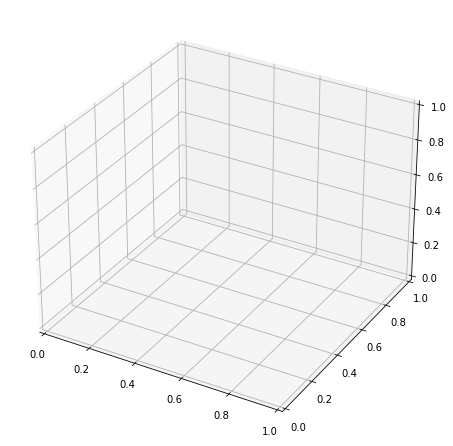

In [14]:
#matplotlib notebook

fig = plt.figure(figsize=(10, 6))
ax = axes3d.Axes3D(fig)

def update_graph(i):
    
    ax.clear()

    Z = interp.griddata((SN["phase"],SN["wave"]),pca.components_[i],(B1,B2),method='cubic')
    #Z = splinemean(B1, B2)
    ax.plot_wireframe(B1, B2, Z)
    ax.plot_surface(B1, B2, Z, cmap=cm.viridis, lw=0.5, rstride=1, cstride=1, alpha=0.6)
    ax.set_xlabel("phase (days)")
    ax.set_ylabel("wavelength (angstrom)")
    ax.set_zlabel("components (a. u.)")


    plt.show()
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)

widgets.interactive(update_graph,i = i)

In [15]:
# training grid
TEMP_PHASE_GRID = np.linspace(-10, 50, 61, dtype=int)
TEMP_WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [16]:
# 2d grid
X_GRID = []
Y_GRID = []
for i in range(0, len(TEMP_PHASE_GRID)):
    for j in range(0, len(TEMP_WAVE_GRID)):
        X_GRID.append(TEMP_PHASE_GRID[i])
        Y_GRID.append(TEMP_WAVE_GRID[j])

In [17]:
# Templates dataset in a pandas dataframe
templates = []
for i in range(N):
    data = [np.array(X_GRID), np.array(Y_GRID), (pca.components_[i].reshape(501, 61).T).reshape(1, len(pca.components_[i]))[0]] # to save as a pandas dataframe
    templates.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(templates))

number of templates generated:  10


## Mean, Standard Deviation and Skewness

In [18]:
# Mean, Standard Deviation and Skewness surfaces
MEAN = np.mean(TRAIN_DATASET, axis=0)
DESVP = np.std(TRAIN_DATASET, axis=0)
SKW = skew(TRAIN_DATASET, axis=0)

STATISTICAL_MOMENTS = [MEAN, DESVP, SKW]

In [19]:
# Given templates in a pandas dataframe
ST_MOM = []
for i in range(3):
    data = [np.array(X_GRID), np.array(Y_GRID), (STATISTICAL_MOMENTS[i].reshape(501, 61).T).reshape(1, len(STATISTICAL_MOMENTS[i]))[0]] # to save as a pandas dataframe
    ST_MOM.append(pd.DataFrame(np.array(data).T, columns=["phase", "wave", "flux"]))
    
print("number of templates generated: ", len(ST_MOM))

number of templates generated:  3


# Generate photometry data

In [20]:
# csp filters using sncosmo
ab = sncosmo.get_magsystem('ab')
# catalog of bands
csp_filtersname = ["cspg", "cspr", "cspv9844"]
csp_filters = [sncosmo.get_bandpass('cspg'), sncosmo.get_bandpass('cspr'), sncosmo.get_bandpass('cspv9844')]

In [21]:
# photometry grid
PHOTO_XGRID = np.linspace(-10, 45, 16, dtype=int)
WAVE_GRID = np.linspace(3500, 8500, 501, dtype=int)

In [22]:
def function_gen(data, dwave=10, returnfun="on"):
    """
    data: pandas dataframe structured with column names as phase, wave and flux
    dwave: differencial wavelength (defaut 10 angstroms)
    returnfun: variable to define what you will want to return. If on it return function, if off return data values
    """
    
    if returnfun == "on":
        functions = []
        for nn in range(0, len(csp_filters)): # run over filters
            temp_flux = []
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # integral element
                temp_flux.append(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))
            functions.append(Spline1d(PHOTO_XGRID, temp_flux)) # save each function to return (number of functions will be the number of filters)
        return functions

    if returnfun == "off":
        
        temp_phase =[]
        temp_flux = []
        temp_eflux = []
        temp_filter = []
        temp_zp = []
        temp_zpsys = []
        for nn in range(0, len(csp_filters)): # run over filters
            for ii in range(0, len(PHOTO_XGRID)): # for each grid point...
                # lists to transform in a pandas dataframe (format of sncosmo fit)
                temp_phase.append(float(PHOTO_XGRID[ii]))
                temp_flux.append(float(np.sum(data[data["phase"]==PHOTO_XGRID[ii]]["flux"]*csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave))) # flux
                temp_eflux.append(float(np.sum(csp_filters[nn](WAVE_GRID)*WAVE_GRID*dwave*data[data["phase"]==PHOTO_XGRID[ii]]["eflux"]))) # error on flux
                temp_filter.append(str(csp_filtersname[nn])) # given bands
                temp_zp.append(2.5*np.log10(ab.zpbandflux(csp_filtersname[nn]))) # zeropoint magnitudes
                temp_zpsys.append("ab") # magnitude format
                temp_data = [temp_phase, temp_flux, temp_eflux, temp_filter, temp_zp, temp_zpsys] # to save as a pandas dataframe
                temp_data = pd.DataFrame(np.array(temp_data).T, columns=["time", "flux", "fluxerr", "band", "zp", "zpsys"]) # collumn names in agreement with sncosmo
        return temp_data

In [23]:
# Filters dictionary
M0_filt = dict({'cspg':function_gen(templates[0])[0],
                'cspr':function_gen(templates[0])[1],
                'cspv9844':function_gen(templates[0])[2]})

M1_filt = dict({'cspg':function_gen(templates[1])[0],
                'cspr':function_gen(templates[1])[1],
                'cspv9844':function_gen(templates[1])[2]})

M2_filt = dict({'cspg':function_gen(templates[2])[0],
                'cspr':function_gen(templates[2])[1],
                'cspv9844':function_gen(templates[2])[2]})

M3_filt = dict({'cspg':function_gen(templates[3])[0],
                'cspr':function_gen(templates[3])[1],
                'cspv9844':function_gen(templates[3])[2]})

M4_filt = dict({'cspg':function_gen(templates[4])[0],
                'cspr':function_gen(templates[4])[1],
                'cspv9844':function_gen(templates[4])[2]})

M5_filt = dict({'cspg':function_gen(templates[5])[0],
                'cspr':function_gen(templates[5])[1],
                'cspv9844':function_gen(templates[5])[2]})

M6_filt = dict({'cspg':function_gen(templates[6])[0],
                'cspr':function_gen(templates[6])[1],
                'cspv9844':function_gen(templates[6])[2]})

M7_filt = dict({'cspg':function_gen(templates[7])[0],
                'cspr':function_gen(templates[7])[1],
                'cspv9844':function_gen(templates[7])[2]})

M8_filt = dict({'cspg':function_gen(templates[8])[0],
                'cspr':function_gen(templates[8])[1],
                'cspv9844':function_gen(templates[8])[2]})

M9_filt = dict({'cspg':function_gen(templates[9])[0],
                'cspr':function_gen(templates[9])[1],
                'cspv9844':function_gen(templates[9])[2]})

# Generating Sintetic fotometry on test data

In [24]:
TEST_DATASET=[]
# use the function above
for i in range(0, len(sn_test)):
    SN = pd.read_csv(".//SN_surfaces//"+str(sn_test[i]),
                           header=None,
                           sep="\s+",
                           names=["phase", "wave", "flux", "eflux"])
    TEST_DATASET.append(SN)

In [25]:
# photometry data
PHOTOMETRY_DATASET_TEST = []
for i in range(0, len(TEST_DATASET)):
    PHOTOMETRY_DATASET_TEST.append(Table(data=Table.from_pandas(function_gen(TEST_DATASET[i], returnfun="off")), dtype=[float, float, float, str, float, str]))

# Models Fit

### SALT2

In [26]:
def salt2_fit(data):
    # create a model
    model = sncosmo.Model(source='salt2') # sncosmo model (salt2)
    model.set(z=0, t0=0) # fixed params
    # run the fit
    result, fitted_model = sncosmo.fit_lc(data, model, ['x0', 'x1', 'c'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (SALT2): ", result.chisq/result.ndof)
    
    #sncosmo.plot_lc(data, model=fitted_model, errors=result.errors);
    
    return fitted_model, result

### Single Expansion Model (Using PCA)

In [27]:
from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2']
    param_names_latex = ['x_0', 'x_1', 'x_2']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)

        self._parameters = np.array([1, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave))

### Single Expansion Model (Using PCA) (x0, x1, x2, x3)

In [28]:
from scipy.interpolate import RectBivariateSpline

class EXP4(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2', 'x3']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, name='EXP4', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)


        self._parameters = np.array([1, 0, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave)) 

### Single Expansion Model (Using PCA) (com todas 10 componentes)

In [29]:
from scipy.interpolate import RectBivariateSpline

# A new class for sncosmo
class EXP10(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, name='EXP10', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9)

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9 = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))

# Light Curve Fits

In [30]:
gridx = np.linspace(-10, 50, 61)
gridy = np.linspace(3500, 8500, 501)

# templates reshaped
M0_reshape = np.array(templates[0]["flux"]).reshape(61, 501) 
M1_reshape = np.array(templates[1]["flux"]).reshape(61, 501)
M2_reshape = np.array(templates[2]["flux"]).reshape(61, 501)
M3_reshape = np.array(templates[3]["flux"]).reshape(61, 501)
M4_reshape = np.array(templates[4]["flux"]).reshape(61, 501)
M5_reshape = np.array(templates[5]["flux"]).reshape(61, 501)
M6_reshape = np.array(templates[6]["flux"]).reshape(61, 501)
M7_reshape = np.array(templates[7]["flux"]).reshape(61, 501)
M8_reshape = np.array(templates[8]["flux"]).reshape(61, 501)
M9_reshape = np.array(templates[9]["flux"]).reshape(61, 501)
c = pd.read_csv(".//Templates//salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]

#exp_mom = EXP_MOM(gridx, gridy, name='EXP_MOM')

## SALT2 x EXP

In [31]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [32]:
def update_graph(i):
    
    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_EXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP4

In [33]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [34]:
def update_graph(i):
    
    exp = EXP4(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, name='EXP4')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP4): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP4"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## SALT2 x EXP10

In [35]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [36]:
def update_graph(i):
    
    exp = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP10): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    #print(result_salt2)
    print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP10"],
                    color="k")
    #plt.savefig('SALT2_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## EXP(3)x EXP10

In [37]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [38]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model1 = sncosmo.Model(source=exp1)
    model1.set(z=0., t0=0)

    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model2 = sncosmo.Model(source=exp2)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP): ", result_exp1.chisq/result_exp.ndof)
    
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP10): ", result_exp2.chisq/result_exp.ndof)

    print(result_exp1.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["EXP(3)", "EXP10"],
                    color="k")
    
    #plt.savefig('EXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

### Single Expansion Model (Using PCA) (x0, x1, x2, c)

In [39]:
from scipy.interpolate import RectBivariateSpline

class EXP3_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'c']
    
    def __init__(self, phase, wave, flux0, flux1, flux2, LC, name='EXP', version='2021'):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2)
        #self._model_flux3  = BicubicInterpolator(phase, wave, flux3)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0])  # initial parameters
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave)) * 10.** (-0.4 * self._model_ext(wave) * c)

In [40]:
def update_graph(i):
    
    exp = EXP3_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0, t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_exp)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [41]:
def free_parameters(ii):
    """
    i:SN train index
    """
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[ii])
    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)
    model.set(z=0., t0=0)
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)
    return result_exp.parameters[2], result_exp.parameters[3], result_exp.parameters[4], result_salt2.parameters[2], result_salt2.parameters[3], result_salt2.parameters[4]

In [42]:
df = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 6)), columns=["x0_exp", "x1_exp", "x2_exp", "x0_salt2", "x1_salt2", "c_salt2"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_salt2, x1_salt2, c_salt2 = free_parameters(i)
    df["x0_exp"][i] = -2.5*np.log10(x0_exp)
    df["x1_exp"][i] = x1_exp
    df["x2_exp"][i] = x2_exp
    df["x0_salt2"][i] = -2.5*np.log10(x0_salt2)
    df["x1_salt2"][i] = x1_salt2
    df["c_salt2"][i] = c_salt2

df.head()

,x0_exp,x1_exp,x2_exp,x0_salt2,x1_salt2,c_salt2
0,16.615014,0.151331,-0.194262,-10.006353,-1.978255,0.010231
1,15.662976,0.039357,-0.099665,-10.825480,0.817999,-0.028820
2,16.150051,0.024179,-0.100025,-10.441617,1.030303,-0.113464
3,16.386403,-0.011292,-0.130305,-10.256491,-0.623808,-0.082235
4,16.226112,0.143455,-0.142416,-10.342505,-0.360031,0.039156


In [43]:
salt2_param_names = {
    0:"x0_salt2",
    1:"x1_salt2",
    2:"c_salt2"
}

salt2_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$c$"
}

exp_param_names = {
    0:"x0_exp",
    1:"x1_exp",
    2:"x2_exp"
}

exp_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}

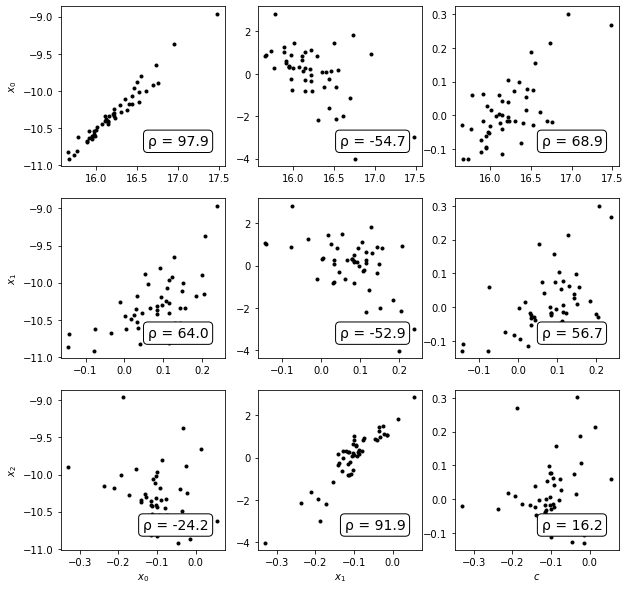

In [44]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        ax[i, j].plot(df[exp_param_names[i]], df[salt2_param_names[j]], 'k.', label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(df[exp_param_names[i]], df[salt2_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp_param_latex[i])
        if i == 2:
            ax[i, j].set_xlabel(salt2_param_latex[j])

In [45]:
exp3_chi2 = []
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):

    exp = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model = sncosmo.Model(source=exp)
    model.set(z=0., t0=0)

    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    exp3_chi2.append(result_exp.chisq/result_exp.ndof)

In [46]:
exp4_chi2 = []
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):

    exp = EXP4(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0.)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'x3'], modelcov=False)  # bounds on parameters (if any)
    exp4_chi2.append(result_exp.chisq/result_exp.ndof)

In [47]:
exp4LC_chi2 = []
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    exp = EXP3_LC(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, c, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0, t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2', 'c'], modelcov=False)  # bounds on parameters (if any)
    exp4LC_chi2.append(result_exp.chisq/result_exp.ndof)

In [48]:
salt2_chi2 = []
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    salt2_chi2.append(result_salt2.chisq/result_salt2.ndof)

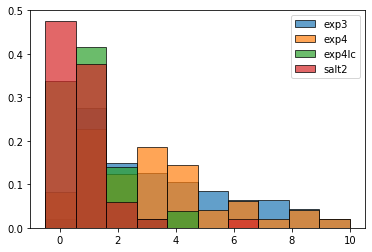

In [49]:
plt.figure()
plt.hist(exp3_chi2, ec = "black", range=(-0.5,10), alpha=0.7, label="exp3", density=True, histtype="bar");
plt.hist(exp4_chi2, ec = "black", range=(-0.5,10), alpha=0.7, label="exp4", density=True, histtype="bar");
plt.hist(exp4LC_chi2, ec = "black", range=(-0.5,10), alpha=0.7, label="exp4lc", density=True, histtype="bar");
plt.hist(salt2_chi2, ec = "black", range=(-0.5,10), alpha=0.7, label="salt2", density=True, histtype="bar");
plt.legend()


## SNEMO2 with c=0

In [50]:
#SNEMO2 = pd.read_csv("/home/joao/Documents/Research/SNFACTORY_SNTRAIN/Templates/snemo2/snemo2_ev.dat",
SNEMO2 = pd.read_csv("./Templates/snemo2/snemo2_ev.dat",
                       sep="\s+",
                       names=["time", "wave", "M0", "M1"])
SNEMO2.head()

,time,wave,M0,M1
0,-20.0,3305.0,0.0,0.0
1,-20.0,3317.0,0.0,0.0
2,-20.0,3328.0,0.0,0.0
3,-20.0,3339.0,0.0,0.0
4,-20.0,3350.0,0.0,0.0


In [51]:
SNEMO2["time"].unique()

array([-20., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,
        10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  60.])

In [52]:
gridx_SNEMO = SNEMO2["time"].unique()
gridy_SNEMO= SNEMO2["wave"].unique()

M0_SNEMO2_reshape = np.array(SNEMO2["M0"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))
M1_SNEMO2_reshape = np.array(SNEMO2["M1"]).reshape(len(SNEMO2["time"].unique()), len(SNEMO2["wave"].unique()))

In [53]:
def update_graph(i):
    
    exp_snemo = EXP(gridx_SNEMO, gridy_SNEMO, M0_SNEMO2_reshape, M1_SNEMO2_reshape, M2_reshape, name='EXP_SNEMO')
    model_0 = sncosmo.Model(source=exp_snemo)

    model_0.set(z=0., t0=0, x2=0)
    
    result_snemo2mod, model_snemo2mod = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model_0, ['x0', 'x1'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (SALT2 modificado): ", result_snemo2mod.chisq/result_snemo2mod.ndof)
    print(result_snemo2mod)
    #SALT2_original
    
    model_1 = sncosmo.Model(source="salt2")

    model_1.set(z=0., t0=0)
    
    result_salt2, model_salt2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model_1, ['x0', 'x1', 'c'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (SALT2 Original): ", result_salt2.chisq/result_salt2.ndof)
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_snemo2mod],
                    errors=[result_salt2.errors, result_snemo2mod.errors],
                    model_label=["SALT2", "SNEMO2"],
                    color="k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

# Finding corrrelations between EXP(3) x EXP10 model coefficients 

In [54]:
def parametros_ajustes(ii):
    """
    i:SN train index
    """   
    exp1 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
        
    model1 = sncosmo.Model(source=exp1)
    model2 = sncosmo.Model(source=exp2)

    model1.set(z=0., t0=0)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)

    return result_exp1.parameters[2], result_exp1.parameters[3], result_exp1.parameters[4], result_exp2.parameters[2], result_exp2.parameters[3], result_exp2.parameters[4], result_exp2.parameters[5], result_exp2.parameters[6], result_exp2.parameters[7], result_exp2.parameters[8], result_exp2.parameters[9], result_exp2.parameters[10], result_exp2.parameters[11]

In [55]:
param_ajuste = pd.DataFrame(data=np.zeros(shape=(len(PHOTOMETRY_DATASET_TEST), 13)), columns=["x0_exp3", "x1_exp3", "x2_exp3", "x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"])
for i in range(0, len(PHOTOMETRY_DATASET_TEST)):
    x0_exp, x1_exp, x2_exp, x0_exp10, x1_exp10, x2_exp10, x3_exp10, x4_exp10, x5_exp10, x6_exp10, x7_exp10, x8_exp10, x9_exp10  = parametros_ajustes(i)
    #param_ajuste["x0_exp3"][i] = -2.5*np.log10(x0_exp)
    param_ajuste["x0_exp3"][i] = x0_exp
    param_ajuste["x1_exp3"][i] = x1_exp
    param_ajuste["x2_exp3"][i] = x2_exp
    #param_ajuste["x0_exp10"][i] = -2.5*np.log10(x0_exp10)
    param_ajuste["x0_exp10"][i] = x0_exp10
    param_ajuste["x1_exp10"][i] = x1_exp10
    param_ajuste["x2_exp10"][i] = x2_exp10
    param_ajuste["x3_exp10"][i] = x3_exp10
    param_ajuste["x4_exp10"][i] = x4_exp10
    param_ajuste["x5_exp10"][i] = x5_exp10
    param_ajuste["x6_exp10"][i] = x6_exp10
    param_ajuste["x7_exp10"][i] = x7_exp10
    param_ajuste["x8_exp10"][i] = x8_exp10
    param_ajuste["x9_exp10"][i] = x9_exp10

param_ajuste.head()

,x0_exp3,x1_exp3,x2_exp3,x0_exp10,x1_exp10,x2_exp10,x3_exp10,x4_exp10,x5_exp10,x6_exp10,x7_exp10,x8_exp10,x9_exp10
0,2.259407e-07,0.151331,-0.194262,1.817299e-07,-0.072800,0.026203,-0.277391,0.264163,0.143221,0.039914,0.020413,0.017647,0.138625
1,5.430122e-07,0.039357,-0.099665,4.241452e-07,-0.034290,-0.087507,-0.039633,0.276892,0.046129,-0.115222,-0.159730,0.327960,-0.234645
2,3.467207e-07,0.024179,-0.100025,3.233779e-07,0.010080,-0.058705,-0.077925,0.001504,0.061765,-0.014897,0.012678,0.009285,0.006493
3,2.788937e-07,-0.011292,-0.130305,2.363189e-07,-0.297466,0.008020,-0.260405,0.236430,-0.007228,0.075734,0.064262,-0.027890,0.088708
4,3.232624e-07,0.143455,-0.142416,2.699555e-07,-0.172459,-0.004406,-0.322720,0.107616,0.090348,0.025253,-0.016278,0.071244,0.056432


In [56]:
exp3_param_names = {
    0:"x0_exp3",
    1:"x1_exp3",
    2:"x2_exp3"
}

exp3_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$"
}
exp10_param_names = {
    0:"x0_exp10",
    1:"x1_exp10",
    2:"x2_exp10",
    3:"x3_exp10",
    4:"x4_exp10",
    5:"x5_exp10",
    6:"x6_exp10",
    7:"x7_exp10",
    8:"x8_exp10",
    9:"x9_exp10"
}

exp10_param_latex = {
    0:"$x_0$",
    1:"$x_1$",
    2:"$x_2$",
    3:"$x_3$",
    4:"$x_4$",
    5:"$x_5$",
    6:"$x_6$",
    7:"$x_7$",
    8:"$x_8$",
    9:"$x_9$"
}

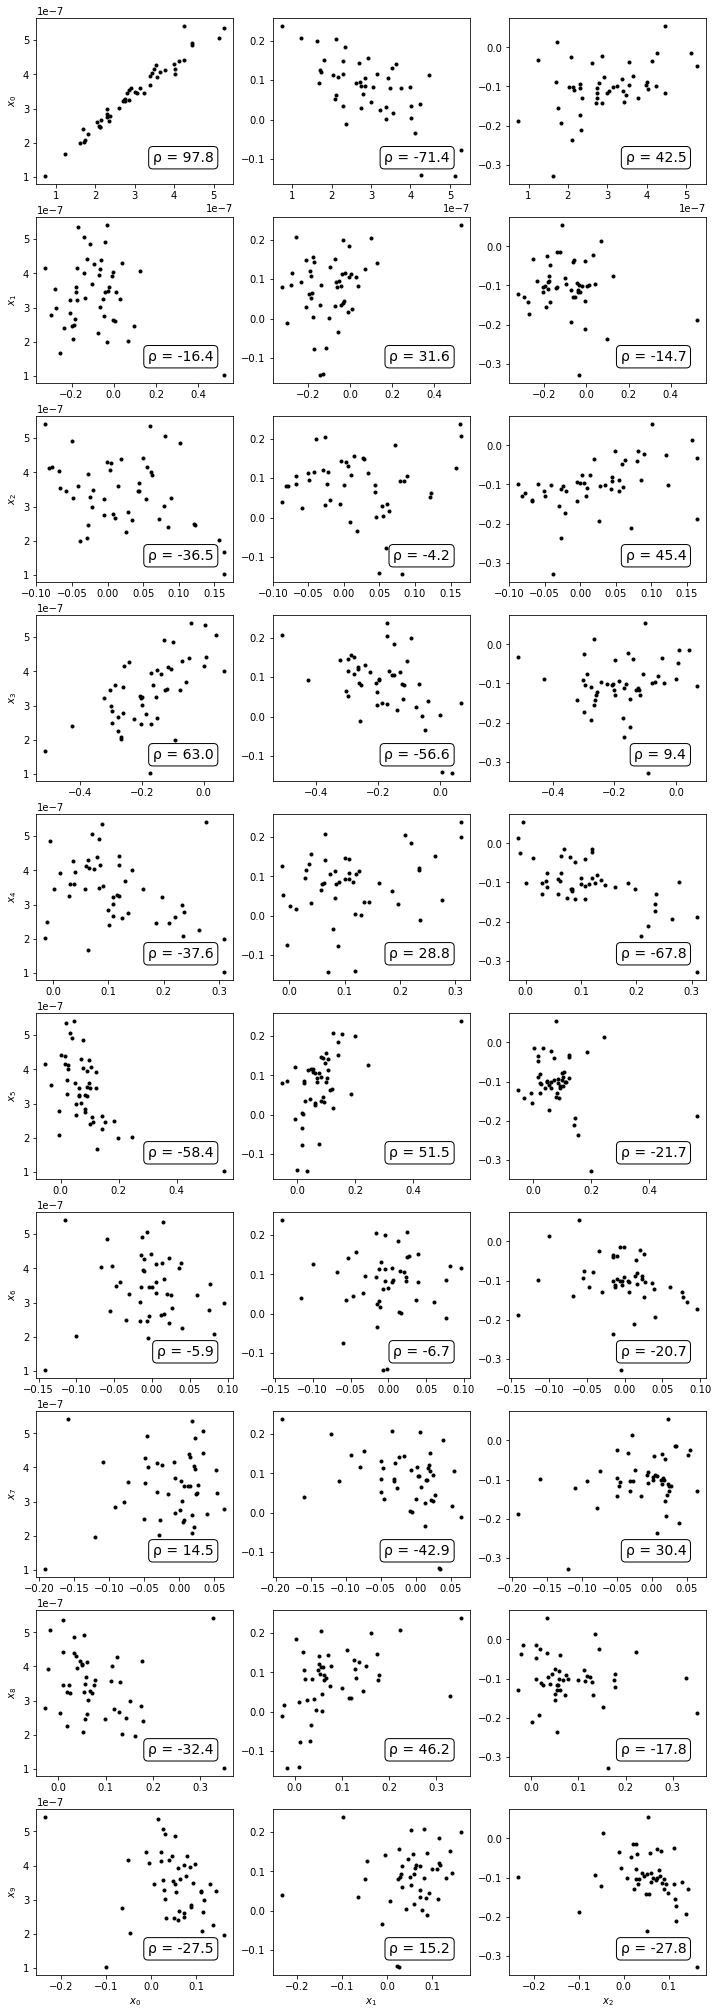

In [57]:
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,36))
for i in range(10):
    for j in range(3):
        ax[i, j].plot(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]], 'k.')#, label=str(round(np.corrcoef(df[salt2_param_names[i]], df[exp_param_names[j]])[0][1]*100, 1)))
        ax[i, j].annotate("ρ = "+str(round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1]*100, 1)), xy=(0.9, .2), xycoords='axes fraction',
                          size=14, ha='right', va='top',
                          bbox=dict(boxstyle='round', fc='w'))
        if j == 0:
            ax[i, j].set_ylabel(exp10_param_latex[i])
        if i == 9:
            ax[i, j].set_xlabel(exp3_param_latex[j])
plt.savefig('correlation.pdf')

In [58]:
correlation_matrix=pd.DataFrame(data=np.zeros(shape=(10, 3)), index=["x0_exp10", "x1_exp10", "x2_exp10", "x3_exp10", "x4_exp10", "x5_exp10", "x6_exp10", "x7_exp10", "x8_exp10", "x9_exp10"],columns=["x0_exp3","x1_exp3","x2_exp3"])
for i in range(10):
    for j in range(3):
        correlation_matrix[exp3_param_names[j]][exp10_param_names[i]]=round(np.corrcoef(param_ajuste[exp10_param_names[i]], param_ajuste[exp3_param_names[j]])[0][1], 4)

In [59]:
correlation_matrix

,x0_exp3,x1_exp3,x2_exp3
x0_exp10,0.9779,-0.7143,0.4245
x1_exp10,-0.1638,0.3155,-0.1473
x2_exp10,-0.3653,-0.0418,0.4540
x3_exp10,0.6302,-0.5656,0.0944
x4_exp10,-0.3763,0.2882,-0.6781
x5_exp10,-0.5843,0.5151,-0.2174
x6_exp10,-0.0588,-0.0669,-0.2071
x7_exp10,0.1449,-0.4285,0.3035
x8_exp10,-0.3243,0.4620,-0.1784
x9_exp10,-0.2747,0.1523,-0.2776


In [60]:
new_M0=np.zeros(shape=M0_reshape.shape)
new_M1=np.zeros(shape=M1_reshape.shape)
new_M2=np.zeros(shape=M2_reshape.shape)
for i in range(10):
    new_M0+=M0_reshape*correlation_matrix["x0_exp3"][exp10_param_names[i]]
    new_M1+=M1_reshape*correlation_matrix["x1_exp3"][exp10_param_names[i]]
    new_M2+=M2_reshape*correlation_matrix["x2_exp3"][exp10_param_names[i]]

## SALT2 x New EXP(3)

In [61]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [62]:
def update_graph(i):
    
    exp = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model = sncosmo.Model(source=exp)

    model.set(z=0., t0=0)
    
    result_exp, model_exp = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    model_salt2, result_salt2 = salt2_fit(PHOTOMETRY_DATASET_TEST[i]);
    print(result_salt2)
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_salt2, model_exp],
                    errors=[result_salt2.errors, result_exp.errors],
                    model_label=["SALT2", "EXP"],
                    color="k")
    #plt.savefig('SALT2_x_NovoEXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## New EXP(3) x EXP10

In [63]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [64]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model1 = sncosmo.Model(source=exp1)
    model1.set(z=0., t0=0)

    exp2 = EXP10(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, M3_reshape, M4_reshape, M5_reshape, M6_reshape, M7_reshape, M8_reshape, M9_reshape, name='EXP10')
    model2 = sncosmo.Model(source=exp2)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP): ", result_exp1.chisq/result_exp.ndof)
    
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], modelcov=False)  # bounds on parameters (if any)
    #print("chi^2 minimum/dof (EXP10): ", result_exp2.chisq/result_exp.ndof)

    print(result_exp1.keys())
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["Novo EXP(3)", "EXP10"],
                    color="k")
    #plt.savefig('NovoEXP_x_EXP10_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

## New EXP(3) x Old EXP(3)

In [65]:
optionslist = []

for i in range(0,len(PHOTOMETRY_DATASET_TEST)):
    
    optionslist.append(i)

In [66]:
def update_graph(i):
    
    exp1 = EXP(gridx, gridy, new_M0, new_M1, new_M2, name='EXP')
    model1 = sncosmo.Model(source=exp1)

    exp2 = EXP(gridx, gridy, M0_reshape, M1_reshape, M2_reshape, name='EXP')
    model2 = sncosmo.Model(source=exp2)

    model1.set(z=0., t0=0)
    model2.set(z=0., t0=0)
    
    result_exp1, model_exp1 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model1, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)
    result_exp2, model_exp2 = sncosmo.fit_lc(PHOTOMETRY_DATASET_TEST[i], model2, ['x0', 'x1', 'x2'], modelcov=False)  # bounds on parameters (if any)

    #print("chi^2 minimum/dof (EXP): ", result_exp.chisq/result_exp.ndof)
    
    sncosmo.plot_lc(PHOTOMETRY_DATASET_TEST[i],
                    model=[model_exp1, model_exp2],
                    errors=[result_exp1.errors, result_exp2.errors],
                    model_label=["novo EXP(3)", "antigo EXP(3)"],
                    color="k")
    #plt.savefig('NovoEXP_x_AntigoEXP_SN'+str(i)+'.pdf')
    
i = widgets.Dropdown(options=optionslist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

In [67]:
new_M0-M0_reshape

array([[-0.02967785, -0.02917983, -0.02838455, ..., -0.00202964,
        -0.00202959, -0.00202957],
       [-0.03020074, -0.02984952, -0.02921706, ..., -0.00211011,
        -0.00211007, -0.00211004],
       [-0.03047879, -0.03027433, -0.02980909, ..., -0.00217958,
        -0.00217954, -0.00217952],
       ...,
       [-0.00018085, -0.00023144, -0.00026113, ..., -0.00046629,
        -0.00046628, -0.00046627],
       [-0.00014208, -0.00018609, -0.0002085 , ..., -0.0004455 ,
        -0.00044549, -0.00044548],
       [-0.00010679, -0.00014311, -0.00015715, ..., -0.00042536,
        -0.00042535, -0.00042534]])